In [1]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
from datetime import time
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from linearmodels import PanelOLS ## Packages for panel regression
#!pip install linearmodels
from statsmodels.formula.api import ols # package for DID estimate
import geopandas as gpd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

## 筛选高街footfall

### 导入高街的hex的ID

In [5]:
# 导入在GIS里筛选出来的位于高街的hexID
hexID = pd.read_csv('data/all_footfall_in_high.csv')
hexID.rename(columns={'Hex_ID': 'hex_id'}, inplace=True)
hexID.rename(columns={'highstreet': 'highstreet_id'}, inplace=True)
hexID.rename(columns={'highstre_1': 'highstreet_name'}, inplace=True)
hexID

,Col_ID,Row_ID,hex_id,Centroid_X,Centroid_Y,area,id,objectid,highstreet_id,highstreet_name,area_ha,gdb_geomat
0,1140.0,1146.0,11401146.0,527210.693200,164250.7975,106088.1150,3.0,3.0,3.0,"Carshalton Road, Carshalton.",4.462210,NaN
1,1141.0,1145.0,11411145.0,527513.802100,164075.7975,106088.1150,3.0,3.0,3.0,"Carshalton Road, Carshalton.",4.462210,NaN
2,1141.0,1147.0,11411147.0,527513.802100,164425.7975,106088.1150,3.0,3.0,3.0,"Carshalton Road, Carshalton.",4.462210,NaN
3,1153.0,1159.0,11531159.0,531151.108800,166525.7975,106088.1150,4.0,4.0,4.0,"Mitcham Road, Croydon.",6.936039,NaN
4,1154.0,1158.0,11541158.0,531454.217700,166350.7975,106088.1150,4.0,4.0,4.0,"Mitcham Road, Croydon.",6.936039,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2578,1121.0,1169.0,11211169.0,521451.624272,168275.7975,106088.0975,638.0,616.0,616.0,"High Street, New Malden",54.888672,NaN
2579,1121.0,1171.0,11211171.0,521451.624272,168625.7975,106088.0975,638.0,616.0,616.0,"High Street, New Malden",54.888672,NaN
2580,1121.0,1173.0,11211173.0,521451.624272,168975.7975,106088.0975,638.0,616.0,616.0,"High Street, New Malden",54.888672,NaN
2581,1122.0,1168.0,11221168.0,521754.733128,168100.7975,106088.0975,638.0,616.0,616.0,"High Street, New Malden",54.888672,NaN


In [6]:
hexID['hex_id'] = hexID['hex_id'].astype(int)

### 处理footfall数据

raw data太大了，这里只放处理步骤

In [54]:
# 导入处理好的（对齐日期、fill过NA值）footfall数据
footfall_23 = pd.read_csv('data/footfall/hex_3hourly_counts_2023.csv')
footfall_22_unmoved = pd.read_csv('data/footfall/hex_3hourly_counts_2022.csv')

In [55]:
# 对齐22年与23年日期
# 确保日期列是datetime类型
footfall_22 = footfall_22_unmoved.copy()
footfall_22['count_date'] = pd.to_datetime(footfall_22['count_date'])

# 使用pd.Timedelta增加一天
footfall_22['count_date'] = footfall_22['count_date'] + pd.Timedelta(days=1)

In [56]:
# 使用fillna(0)将NA值替换为0，保证下一步均值计算将夜间NA值纳入
footfall_23 = footfall_23.fillna(0)
footfall_22 = footfall_22.fillna(0)

In [57]:
# 根据ID筛选出高街的footfall数据
footfall_23 = footfall_23[footfall_23['hex_id'].isin(hexID['hex_id'])]
footfall_22 = footfall_22[footfall_22['hex_id'].isin(hexID['hex_id'])]

筛选出高街内的hex后

In [58]:
# 计算每个hex的每日footfall
footfall_23_daily_byhex = (
    footfall_23.groupby(["count_date", "hex_id"])
    .agg(
        daily_resident_byID=("resident", "mean"),
        daily_visitor_byID=("visitor", "mean"),
        daily_worker_byID=("worker", "mean"))
    .reset_index()
)
footfall_22_daily_byhex = (
    footfall_22.groupby(["count_date", "hex_id"])
    .agg(
        daily_resident_byID=("resident", "mean"),
        daily_visitor_byID=("visitor", "mean"),
        daily_worker_byID=("worker", "mean"))
    .reset_index()
)

In [59]:
# 添加高街的属性数据
footfall_high_street_all_23 = pd.merge(footfall_23_daily_byhex, hexID, left_on='hex_id', right_on='hex_id')
footfall_high_street_all_22 = pd.merge(footfall_22_daily_byhex, hexID, left_on='hex_id', right_on='hex_id')

In [60]:
footfall_high_street_all_22.head()

,count_date,hex_id,daily_resident_byID,daily_visitor_byID,daily_worker_byID,Col_ID,Row_ID,Centroid_X,Centroid_Y,area,id,objectid,highstreet_id,highstreet_name,area_ha,gdb_geomat
0,2022-05-02,10661254,29.428571,7.428571,1.428571,1066.0,1254.0,504780.6352,183150.7975,106088.115,105.0,104.0,104.0,"St John?s Road, Uxbridge.",5.678109,NaN
1,2022-05-03,10661254,36.250000,25.625000,13.875000,1066.0,1254.0,504780.6352,183150.7975,106088.115,105.0,104.0,104.0,"St John?s Road, Uxbridge.",5.678109,NaN
2,2022-05-04,10661254,47.500000,95.375000,130.750000,1066.0,1254.0,504780.6352,183150.7975,106088.115,105.0,104.0,104.0,"St John?s Road, Uxbridge.",5.678109,NaN
3,2022-05-05,10661254,52.000000,51.625000,130.750000,1066.0,1254.0,504780.6352,183150.7975,106088.115,105.0,104.0,104.0,"St John?s Road, Uxbridge.",5.678109,NaN
4,2022-05-06,10661254,72.875000,92.250000,158.125000,1066.0,1254.0,504780.6352,183150.7975,106088.115,105.0,104.0,104.0,"St John?s Road, Uxbridge.",5.678109,NaN


In [61]:
# 计算每个高街的每日footfall(将hex在高街层面聚集)
footfall_23_daily = (
    footfall_high_street_all_23.groupby(["count_date","highstreet_id","highstreet_name"])
    .agg(
        daily_resident=("daily_resident_byID", "mean"),
        daily_visitor=("daily_visitor_byID", "mean"),
        daily_worker=("daily_worker_byID", "mean"))
    .reset_index()
)
footfall_22_daily = (
    footfall_high_street_all_22.groupby(["count_date","highstreet_id","highstreet_name"])
    .agg(
        daily_resident=("daily_resident_byID", "mean"),
        daily_visitor=("daily_visitor_byID", "mean"),
        daily_worker=("daily_worker_byID", "mean"))
    .reset_index()
)

In [62]:
footfall_23_daily.to_csv('data/footfall/footfall_23_daily.csv', index=True)
footfall_22_daily.to_csv('data/footfall/footfall_22_daily.csv', index=True)

# 从这里开始跑（前面是数据处理

In [63]:
footfall_23_daily = pd.read_csv('data/footfall/footfall_23_daily.csv')
footfall_22_daily = pd.read_csv('data/footfall/footfall_22_daily.csv')

In [64]:
footfall_22_daily

,Unnamed: 0,count_date,highstreet_id,highstreet_name,daily_resident,daily_visitor,daily_worker
0,0,2022-05-02,3.0,"Carshalton Road, Carshalton.",309.619048,46.857143,11.857143
1,1,2022-05-02,4.0,"Mitcham Road, Croydon.",575.619048,154.666667,30.904762
2,2,2022-05-02,5.0,"Bridge Road, Chessington.",510.928571,86.500000,22.785714
3,3,2022-05-02,6.0,"Brighton Road, Purley Oaks.",331.857143,111.342857,22.885714
4,4,2022-05-02,7.0,"Brighton Road, South Croydon.",315.666667,86.714286,18.238095
...,...,...,...,...,...,...,...
98896,98896,2023-01-01,606.0,"High Street, Colliers Wood",702.602273,405.840909,99.397727
98897,98897,2023-01-01,609.0,"Lea Bridge Road/High Road, Leyton",755.018750,265.512500,69.537500
98898,98898,2023-01-01,613.0,"Seven Sisters Road & Blackstock Road, Finsbury...",1027.192308,502.519231,123.653846
98899,98899,2023-01-01,615.0,"Kingston Road, South Wimbledon",613.400000,216.862500,45.950000


In [65]:
# 计算全外伦敦高街的每日footfall，用于打图观察整体变化
footfall_23_avg_high = (
    footfall_23_daily.groupby(["count_date"])
    .agg(
        daily_resident_byallhigh=("daily_resident", "mean"),
        daily_visitor_byallhigh=("daily_visitor", "mean"),
        daily_worker_byallhigh=("daily_worker", "mean"))
    .reset_index()
)
footfall_22_avg_high = (
    footfall_22_daily.groupby(["count_date"])
    .agg(
        daily_resident_byallhigh=("daily_resident", "mean"),
        daily_visitor_byallhigh=("daily_visitor", "mean"),
        daily_worker_byallhigh=("daily_worker", "mean"))
    .reset_index()
)

### 筛选study period

In [66]:
# 筛选出study period，即ULEZ发布前后各8周的footfall
footfall_23_mini = footfall_23_daily[(footfall_23_daily['count_date'] > "2023-07-04") & (footfall_23_daily['count_date'] < "2023-10-24")]
footfall_22_mini = footfall_22_daily[(footfall_22_daily['count_date'] > "2022-07-04") & (footfall_22_daily['count_date'] < "2022-10-24")]

In [67]:
high_2223 = pd.concat([footfall_22_avg_high, footfall_23_avg_high])

In [68]:
# 处理打图用的全外外伦敦平均日footfall的outliers
def filter_outliers(var):
    q1 = var.quantile(0.25) # calculate the first quartile
    q3 = var.quantile(0.75) # calculate the third quartile
    iqr = q3 - q1 # calculate the interquartile range
    low = q1 - 1.5*iqr # calculate the lower bound
    high = q3 + 1.5*iqr # calculate the upper bound
    filtered = high_2223[(var > low) & (var < high)] # filter  the values that are within the bounds
    dropped_observations= len(var)-len(filtered) # calculate the number of observations that were dropped

    print('Dropped {} observations'.format(dropped_observations))
    return  filtered

high_2223 =filter_outliers(high_2223['daily_visitor_byallhigh'])

Dropped 18 observations


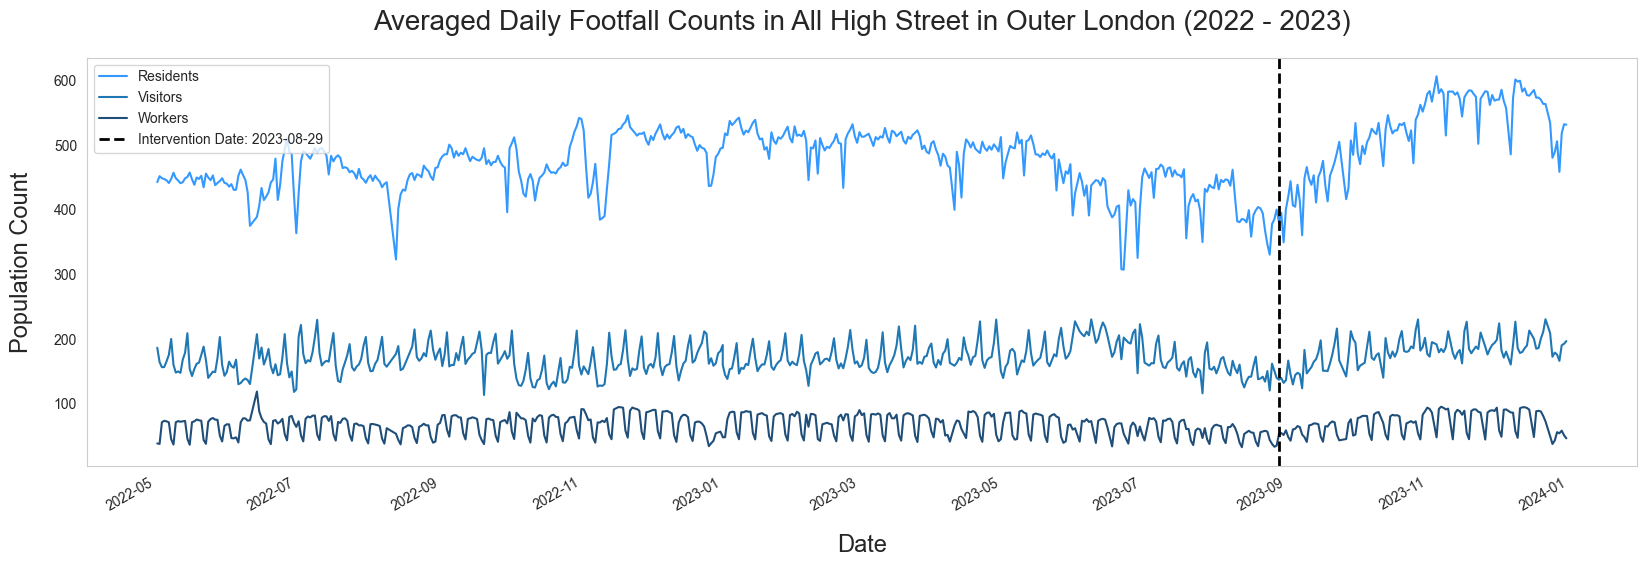

In [69]:
# 确保 'count_date' 列是日期格式
high_2223['count_date'] = pd.to_datetime(high_2223['count_date'])
# 设置 'count_date' 为 DataFrame 的索引
high_2223.set_index('count_date', inplace=True)

# 绘制折线图
plt.figure(figsize=(20, 6))

# 绘制折线
plt.plot(high_2223.index, high_2223['daily_resident_byallhigh'], label='Residents', color='#3399ff')
plt.plot(high_2223.index, high_2223['daily_visitor_byallhigh'], label='Visitors', color='#1f77b4')
plt.plot(high_2223.index, high_2223['daily_worker_byallhigh'], label='Workers', color='#1f4e79')

# 添加垂直线
plt.axvline(pd.Timestamp('2023-08-29'), color='black', linestyle='--', linewidth=2, label='Intervention Date: 2023-08-29')

# 移除网格
plt.grid(False)

# 添加图例，并设置图例在左上角
plt.legend(loc='upper left')

# 添加标题和标签，设置 pad 参数以调整标题和标签的距离
plt.title('Averaged Daily Footfall Counts in All High Street in Outer London (2022 - 2023)', fontsize=20, pad=20)
plt.xlabel('Date', fontsize=17, labelpad=15)
plt.ylabel('Population Count', fontsize=17, labelpad=15)

# 美化 x 轴日期显示
plt.gcf().autofmt_xdate()

# 显示图表
plt.show()

In [70]:
# 处理用于跑分段折线图的22和23年数据的outliers
def filter_outliers(var):
    q1 = var.quantile(0.25) # calculate the first quartile
    q3 = var.quantile(0.75) # calculate the third quartile
    iqr = q3 - q1 # calculate the interquartile range
    low = q1 - 1.5*iqr # calculate the lower bound
    high = q3 + 1.5*iqr # calculate the upper bound
    filtered = footfall_22_mini[(var > low) & (var < high)] # filter  the values that are within the bounds
    dropped_observations= len(var)-len(filtered) # calculate the number of observations that were dropped

    print('Dropped {} observations'.format(dropped_observations))
    return  filtered

footfall_22_mini_filtered =filter_outliers(footfall_22_mini['daily_visitor']) # filter outliers from realhrwage

def filter_outliers(var):
    q1 = var.quantile(0.25) # calculate the first quartile
    q3 = var.quantile(0.75) # calculate the third quartile
    iqr = q3 - q1 # calculate the interquartile range
    low = q1 - 1.5*iqr # calculate the lower bound
    high = q3 + 1.5*iqr # calculate the upper bound
    filtered = footfall_23_mini[(var > low) & (var < high)] # filter  the values that are within the bounds
    dropped_observations= len(var)-len(filtered) # calculate the number of observations that were dropped

    print('Dropped {} observations'.format(dropped_observations))
    return  filtered

footfall_23_mini_filtered =filter_outliers(footfall_23_mini['daily_visitor']) # filter outliers from realhrwage

Dropped 2397 observations
Dropped 2527 observations


## 画分段回归折线图，可视化match与unmatched的组

In [71]:
# 在打图之前，修改年份到23年，统一横坐标
footfall_22_mini_filtered['count_date'] = pd.to_datetime(footfall_22_mini_filtered['count_date'])
footfall_22_mini_filtered['count_date'] = footfall_22_mini_filtered['count_date'].apply(lambda x: x.replace(year=2023))

/var/folders/xg/n6zqnqhs57n1ytjkwjmsz9qr0000gn/T/ipykernel_88054/1676145584.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  footfall_22_mini_filtered['count_date'] = pd.to_datetime(footfall_22_mini_filtered['count_date'])
/var/folders/xg/n6zqnqhs57n1ytjkwjmsz9qr0000gn/T/ipykernel_88054/1676145584.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  footfall_22_mini_filtered['count_date'] = footfall_22_mini_filtered['count_date'].apply(lambda x: x.replace(year=2023))


/var/folders/xg/n6zqnqhs57n1ytjkwjmsz9qr0000gn/T/ipykernel_88054/2416876522.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  footfall_23_mini_filtered['count_date'] = pd.to_datetime(footfall_23_mini_filtered['count_date'])
/var/folders/xg/n6zqnqhs57n1ytjkwjmsz9qr0000gn/T/ipykernel_88054/2416876522.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  footfall_22_mini_filtered['count_date'] = pd.to_datetime(footfall_22_mini_filtered['count_date'])
/var/folders/xg/n6zqnqhs57n1ytjkwjmsz9qr0000gn/T/ipykernel_8

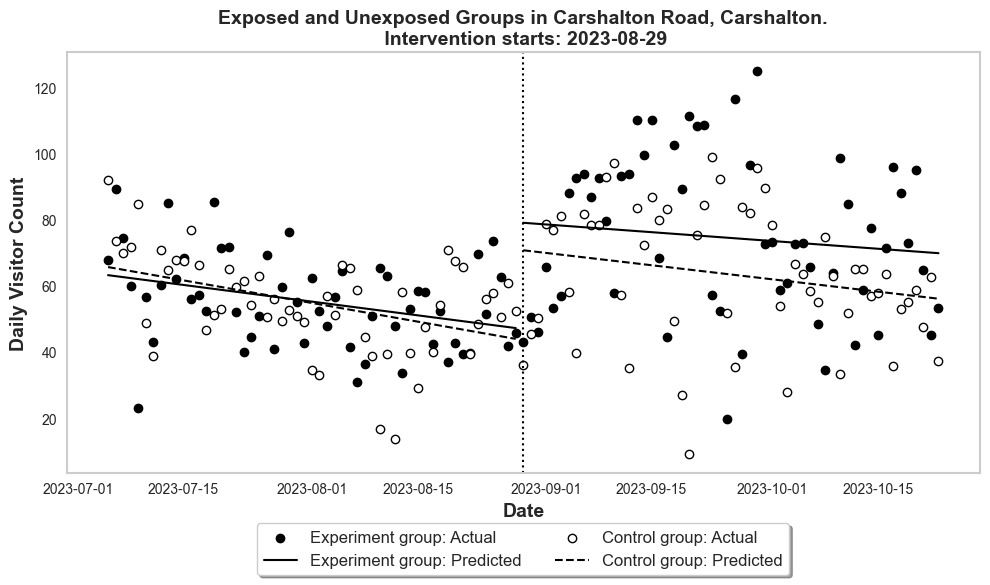

/var/folders/xg/n6zqnqhs57n1ytjkwjmsz9qr0000gn/T/ipykernel_88054/2416876522.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  footfall_23_subset['daily_visitor'] = pd.to_numeric(footfall_23_subset['daily_visitor'], errors='coerce')
/var/folders/xg/n6zqnqhs57n1ytjkwjmsz9qr0000gn/T/ipykernel_88054/2416876522.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  footfall_22_subset['daily_visitor'] = pd.to_numeric(footfall_22_subset['daily_visitor'], errors='coerce')
/var/folders/xg/n6zqnqhs57n1ytjkwjmsz9qr00

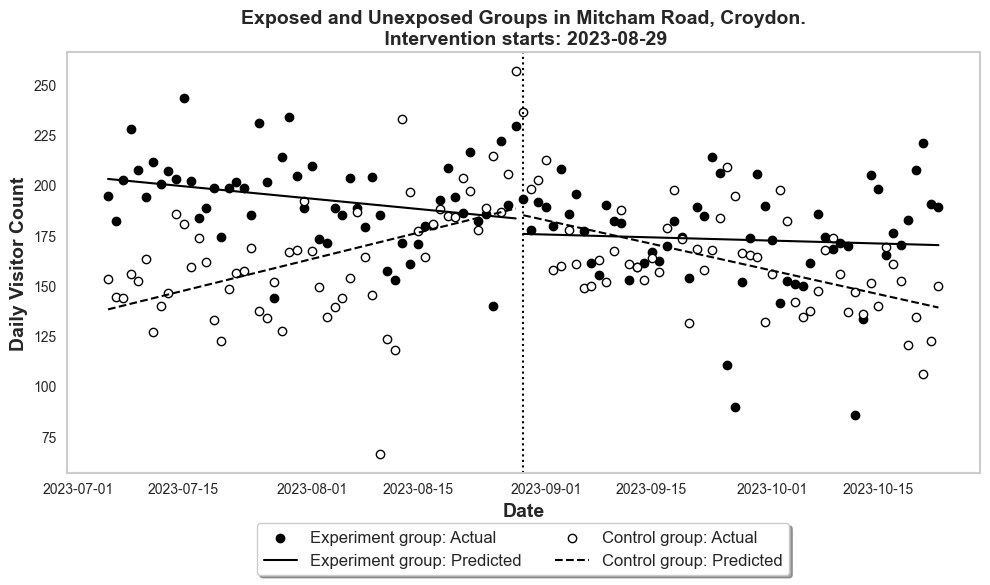

/var/folders/xg/n6zqnqhs57n1ytjkwjmsz9qr0000gn/T/ipykernel_88054/2416876522.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  footfall_23_subset['daily_visitor'] = pd.to_numeric(footfall_23_subset['daily_visitor'], errors='coerce')
/var/folders/xg/n6zqnqhs57n1ytjkwjmsz9qr0000gn/T/ipykernel_88054/2416876522.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  footfall_22_subset['daily_visitor'] = pd.to_numeric(footfall_22_subset['daily_visitor'], errors='coerce')
/var/folders/xg/n6zqnqhs57n1ytjkwjmsz9qr00

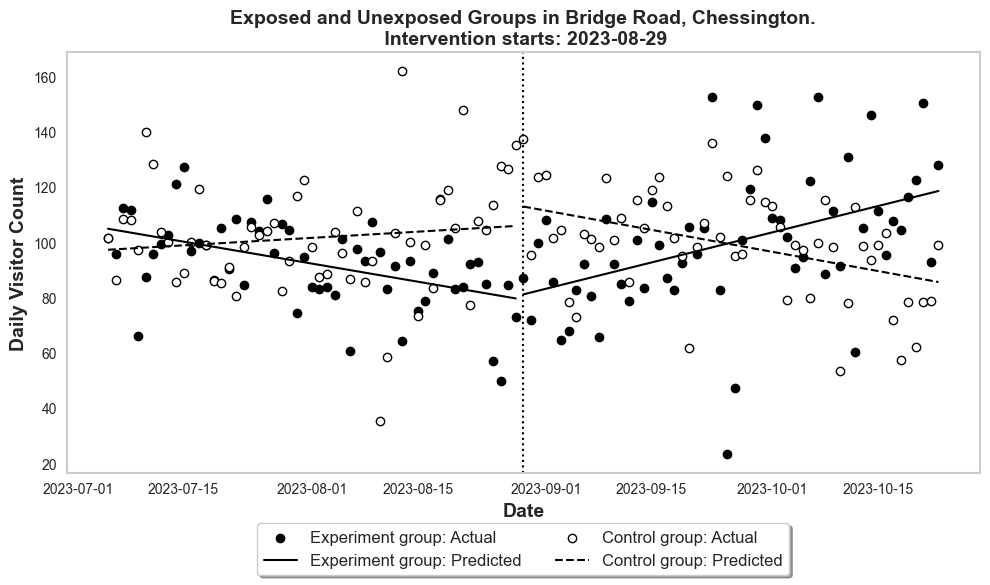

/var/folders/xg/n6zqnqhs57n1ytjkwjmsz9qr0000gn/T/ipykernel_88054/2416876522.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  footfall_23_subset['daily_visitor'] = pd.to_numeric(footfall_23_subset['daily_visitor'], errors='coerce')
/var/folders/xg/n6zqnqhs57n1ytjkwjmsz9qr0000gn/T/ipykernel_88054/2416876522.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  footfall_22_subset['daily_visitor'] = pd.to_numeric(footfall_22_subset['daily_visitor'], errors='coerce')
/var/folders/xg/n6zqnqhs57n1ytjkwjmsz9qr00

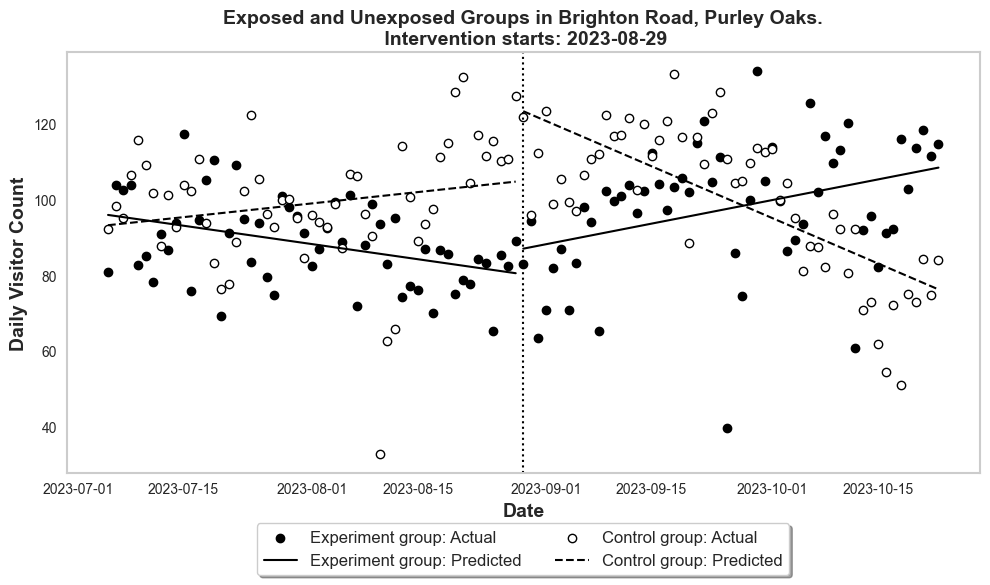

/var/folders/xg/n6zqnqhs57n1ytjkwjmsz9qr0000gn/T/ipykernel_88054/2416876522.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  footfall_23_subset['daily_visitor'] = pd.to_numeric(footfall_23_subset['daily_visitor'], errors='coerce')
/var/folders/xg/n6zqnqhs57n1ytjkwjmsz9qr0000gn/T/ipykernel_88054/2416876522.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  footfall_22_subset['daily_visitor'] = pd.to_numeric(footfall_22_subset['daily_visitor'], errors='coerce')
/var/folders/xg/n6zqnqhs57n1ytjkwjmsz9qr00

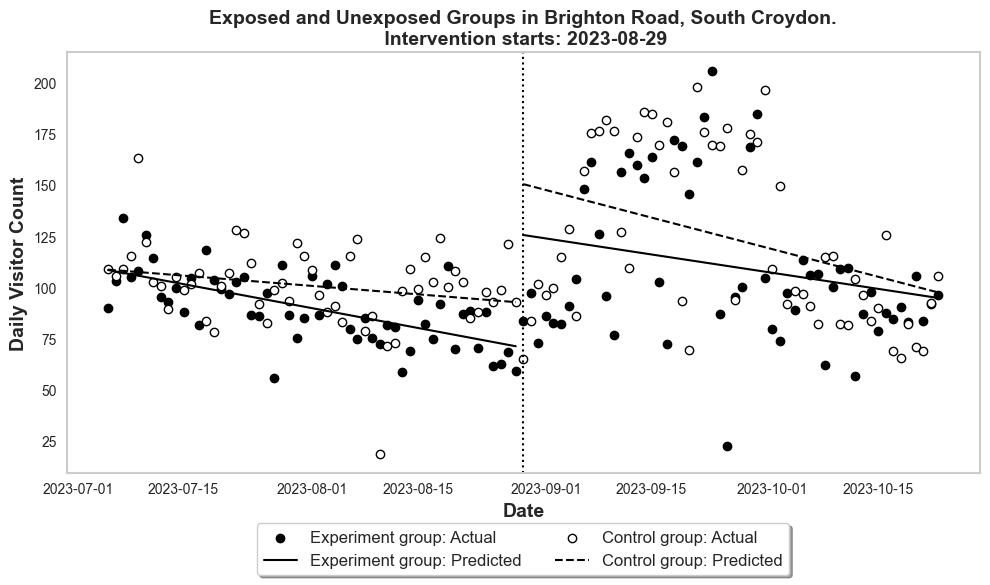

In [72]:
# 确保 count_date 列是日期类型
footfall_23_mini_filtered['count_date'] = pd.to_datetime(footfall_23_mini_filtered['count_date'])
footfall_22_mini_filtered['count_date'] = pd.to_datetime(footfall_22_mini_filtered['count_date'])

# 设置干预日期
intervention_date = pd.to_datetime('2023-08-29')

# 分段回归函数
def segmented_regression(x, y, break_point):
    x1 = x[x < break_point]
    y1 = y[x < break_point]
    x2 = x[x >= break_point]
    y2 = y[x >= break_point]
    
    # 拟合分段回归模型
    model1 = OLS(y1, add_constant(x1)).fit()
    model2 = OLS(y2, add_constant(x2)).fit()
    
    return model1, model2

# 获取 unique 的 highstreet_name 列，并只取前 5 个
unique_highstreets = footfall_23_mini_filtered['highstreet_name'].unique()[:5]

# 循环处理每个 highstreet_name
for highstreet_name in unique_highstreets:
    # 过滤出该 highstreet_name 对应的数据
    footfall_23_subset = footfall_23_mini_filtered[footfall_23_mini_filtered['highstreet_name'] == highstreet_name]
    footfall_22_subset = footfall_22_mini_filtered[footfall_22_mini_filtered['highstreet_name'] == highstreet_name]
    
    # 确保 daily_visitor 列为数值类型
    footfall_23_subset['daily_visitor'] = pd.to_numeric(footfall_23_subset['daily_visitor'], errors='coerce')
    footfall_22_subset['daily_visitor'] = pd.to_numeric(footfall_22_subset['daily_visitor'], errors='coerce')

    # 转换日期为时间戳
    footfall_23_subset['timestamp'] = footfall_23_subset['count_date'].map(pd.Timestamp.timestamp)
    footfall_22_subset['timestamp'] = footfall_22_subset['count_date'].map(pd.Timestamp.timestamp)
    intervention_timestamp = intervention_date.timestamp()

    # 绘制图表
    plt.figure(figsize=(10, 6))

    # 实验组数据
    model1_exp, model2_exp = segmented_regression(footfall_23_subset['timestamp'], footfall_23_subset['daily_visitor'], intervention_timestamp)
    plt.scatter(footfall_23_subset['count_date'], footfall_23_subset['daily_visitor'], color='black', label=f'Experiment group: Actual')
    plt.plot(footfall_23_subset['count_date'][footfall_23_subset['count_date'] < intervention_date], model1_exp.predict(add_constant(footfall_23_subset['timestamp'][footfall_23_subset['count_date'] < intervention_date])), color='black', linestyle='-', label=f'Experiment group: Predicted')
    plt.plot(footfall_23_subset['count_date'][footfall_23_subset['count_date'] >= intervention_date], model2_exp.predict(add_constant(footfall_23_subset['timestamp'][footfall_23_subset['count_date'] >= intervention_date])), color='black', linestyle='-')

    # 对照组数据
    model1_ctrl, model2_ctrl = segmented_regression(footfall_22_subset['timestamp'], footfall_22_subset['daily_visitor'], intervention_timestamp)
    plt.scatter(footfall_22_subset['count_date'], footfall_22_subset['daily_visitor'], color='white', edgecolor='black', label=f'Control group: Actual')
    plt.plot(footfall_22_subset['count_date'][footfall_22_subset['count_date'] < intervention_date], model1_ctrl.predict(add_constant(footfall_22_subset['timestamp'][footfall_22_subset['count_date'] < intervention_date])), color='black', linestyle='--', label=f'Control group: Predicted')
    plt.plot(footfall_22_subset['count_date'][footfall_22_subset['count_date'] >= intervention_date], model2_ctrl.predict(add_constant(footfall_22_subset['timestamp'][footfall_22_subset['count_date'] >= intervention_date])), color='black', linestyle='--')

    # 垂直线
    plt.axvline(x=intervention_date, color='black', linestyle='dotted')

    # 标签和标题
    plt.xlabel('Date', fontsize=14, fontweight='bold')
    plt.ylabel('Daily Visitor Count', fontsize=14, fontweight='bold')
    plt.title(f'Exposed and Unexposed Groups in {highstreet_name}\n Intervention starts: 2023-08-29', fontsize=14, fontweight='bold')
    plt.legend(loc='upper center', fontsize=12, bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=2)

    # 保留横线网格，去除竖线
    ax = plt.gca()
    ax.grid(False) 
    
    # 加粗边框
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)  # 设置边框宽度
    
    # 布局调整
    plt.tight_layout()
    
    # 显示图表
    plt.show()

## level 1模型 (第一次ITS）

### 添加model的变量

In [73]:
# # 添加变量，处理组为1，控制组为0
footfall_23_mini['exposed'] = 1
footfall_22_mini['exposed'] = 0

# 修改年份
footfall_22_mini['count_date'] = pd.to_datetime(footfall_22_mini['count_date'])
footfall_22_mini['count_date'] = footfall_22_mini['count_date'].apply(lambda x: x.replace(year=2023))

# 合并22和23数据
footfall_ITS = pd.concat([footfall_22_mini, footfall_23_mini])
footfall_ITS.head()

/var/folders/xg/n6zqnqhs57n1ytjkwjmsz9qr0000gn/T/ipykernel_88054/3618928484.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  footfall_23_mini['exposed'] = 1
/var/folders/xg/n6zqnqhs57n1ytjkwjmsz9qr0000gn/T/ipykernel_88054/3618928484.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  footfall_22_mini['exposed'] = 0
/var/folders/xg/n6zqnqhs57n1ytjkwjmsz9qr0000gn/T/ipykernel_88054/3618928484.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

,Unnamed: 0,count_date,highstreet_id,highstreet_name,daily_resident,daily_visitor,daily_worker,exposed
25234,25234,2023-07-05 00:00:00,3.0,"Carshalton Road, Carshalton.",352.833333,91.916667,65.833333,0
25235,25235,2023-07-05 00:00:00,4.0,"Mitcham Road, Croydon.",676.916667,153.291667,43.541667,0
25236,25236,2023-07-05 00:00:00,5.0,"Bridge Road, Chessington.",514.437500,101.562500,42.250000,0
25237,25237,2023-07-05 00:00:00,6.0,"Brighton Road, Purley Oaks.",376.175000,92.350000,55.450000,0
25238,25238,2023-07-05 00:00:00,7.0,"Brighton Road, South Croydon.",352.041667,109.125000,99.875000,0


In [74]:
# 根据ITS公式添加变量

intervention_date = pd.Timestamp('2023-08-29')

footfall_ITS['count_date'] = pd.to_datetime(footfall_ITS['count_date'])
footfall_ITS['DayofWeek'] = footfall_ITS['count_date'].dt.strftime('%a')

# 创建time项
footfall_ITS['time'] = footfall_ITS.apply(
    lambda row: (row['count_date'] - footfall_ITS['count_date'].min()).days 
                if row['count_date'] < intervention_date 
                else (row['count_date'] - intervention_date).days,
    axis=1
)

# 创建intervention项
footfall_ITS['intervention'] = (footfall_ITS['count_date'] >= '2023-08-29').astype(int)

# 创建 intervention*time交互项
footfall_ITS['intervention*time'] = footfall_ITS['intervention'] * footfall_ITS['time']

# 创建 exposed*time项
footfall_ITS['exposed*time'] = footfall_ITS['exposed'] * footfall_ITS['time']

# 创建 exposed*intervention项
footfall_ITS['exposed*intervention'] = footfall_ITS['exposed'] * footfall_ITS['intervention']

# 创建 exposed*intervention*time交互项
footfall_ITS['exposed*intervention*time'] = footfall_ITS['exposed'] * footfall_ITS['intervention*time']

footfall_ITS.head()

,Unnamed: 0,count_date,highstreet_id,highstreet_name,daily_resident,daily_visitor,daily_worker,exposed,DayofWeek,time,intervention,intervention*time,exposed*time,exposed*intervention,exposed*intervention*time
25234,25234,2023-07-05,3.0,"Carshalton Road, Carshalton.",352.833333,91.916667,65.833333,0,Wed,0,0,0,0,0,0
25235,25235,2023-07-05,4.0,"Mitcham Road, Croydon.",676.916667,153.291667,43.541667,0,Wed,0,0,0,0,0,0
25236,25236,2023-07-05,5.0,"Bridge Road, Chessington.",514.437500,101.562500,42.250000,0,Wed,0,0,0,0,0,0
25237,25237,2023-07-05,6.0,"Brighton Road, Purley Oaks.",376.175000,92.350000,55.450000,0,Wed,0,0,0,0,0,0
25238,25238,2023-07-05,7.0,"Brighton Road, South Croydon.",352.041667,109.125000,99.875000,0,Wed,0,0,0,0,0,0


### 筛选存在对照组的高街

In [75]:
# 筛选beta_5
# 获取所有独特的 highstreet_name 作为 regions
regions = footfall_ITS['highstreet_name'].unique()

models = []
coefficients = {}
non_significant_beta5 = []  # 用于收集数据以创建DataFrame

for region in regions:
    region_data = footfall_ITS[footfall_ITS['highstreet_name'] == region]
    model = ols('daily_visitor ~ time + intervention + intervention*time + exposed + exposed*time + exposed*intervention + exposed*intervention*time + C(DayofWeek)', data=region_data).fit()
    models.append(model)
    
    # 存储所有系数
    coefficients[region] = {
        'highstreet_name': region,
        'beta_0': model.params.get('Intercept', float('nan')),
        'beta_1': model.params.get('time', float('nan')),
        'beta_2': model.params.get('intervention', float('nan')),
        'beta_3': model.params.get('intervention:time', float('nan')),
        'beta_4': model.params.get('exposed', float('nan')),
        'beta_5': model.params.get('exposed:time', float('nan')),
        'beta_6': model.params.get('intervention:time', float('nan')),
        'beta_7': model.params.get('exposed:intervention:time', float('nan')),
        'beta_8': model.params.get('C(DayofWeek)[T.Mon]', float('nan')),
        'beta_9': model.params.get('C(DayofWeek)[T.Tue]', float('nan')),
        'beta_10': model.params.get('C(DayofWeek)[T.Wed]', float('nan')),
        'beta_11': model.params.get('C(DayofWeek)[T.Thu]', float('nan')),
        'beta_12': model.params.get('C(DayofWeek)[T.Sat]', float('nan')),
        'beta_13': model.params.get('C(DayofWeek)[T.Sun]', float('nan'))
    }
    
    # 检查beta_5的p-value是否大于0.05
    if model.pvalues['exposed:time'] > 0.05:
        non_significant_beta5.append(coefficients[region])

# 创建一个DataFrame来存储不显著beta_5的模型系数
df_non_significant_beta5 = pd.DataFrame(non_significant_beta5)

df_non_significant_beta5

,highstreet_name,beta_0,beta_1,beta_2,beta_3,beta_4,beta_5,beta_6,beta_7,beta_8,beta_9,beta_10,beta_11,beta_12,beta_13
0,"Carshalton Road, Carshalton.",74.817730,-0.384572,5.755602,0.116915,-2.442899,0.105929,0.116915,-0.006915,-14.974843,-19.114975,-7.563646,-7.065591,-7.675642,-11.917604
1,"Brighton Road, South Croydon.",117.922217,-0.300894,42.504889,-0.688003,-0.191340,-0.395768,-0.688003,0.799049,-6.117825,-19.385965,-14.226138,-7.478173,-6.826601,-10.983064
2,"Hook Road, Surbiton",83.066431,-0.109779,29.985639,-0.450742,12.419939,-0.417542,-0.450742,0.969354,-5.588744,-10.118454,-8.601862,-0.633179,4.504707,1.322174
3,"Central Road, Worcester Park.",163.986352,-0.351960,1.614685,-0.384284,-5.874159,-0.451324,-0.384284,2.077487,6.255085,-17.836131,-15.775786,-15.964820,17.110549,3.865369
4,"Manor Road, Wallington.",181.685000,-0.674826,-15.054470,0.359390,-22.244585,-0.346976,0.359390,1.436562,6.484424,-12.251818,-11.171040,-17.734218,-4.646685,5.236404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,"Maple Road, Green Lane & High Street, Parish L...",174.161819,-0.442371,-12.130394,-0.452500,-1.309938,-0.425025,-0.452500,1.615012,17.371921,2.420664,-10.391393,-13.714816,15.141118,19.979501
233,"High Street, Colliers Wood",317.744904,0.528725,52.289981,-2.464956,-10.316319,-0.589105,-2.464956,3.216277,41.627807,-1.019641,-13.457956,-22.175510,44.451338,29.750191
234,"Lea Bridge Road/High Road, Leyton",261.674829,-0.518308,-19.917227,-0.326290,-32.253262,0.055397,-0.326290,1.795991,10.308409,-5.535133,-13.761140,-20.486735,6.988350,12.843080
235,"Seven Sisters Road & Blackstock Road, Finsbury...",670.065818,-6.447169,-229.550185,4.746145,45.925117,-0.749598,4.746145,4.048263,74.405440,24.322938,-65.048138,-77.409706,68.137250,103.892629


In [76]:
# 根据beta_5的筛选
footfall_for_Level1 = footfall_ITS[footfall_ITS['highstreet_name'].isin(df_non_significant_beta5['highstreet_name'])]

In [77]:
footfall_for_Level1

,Unnamed: 0,count_date,highstreet_id,highstreet_name,daily_resident,daily_visitor,daily_worker,exposed,DayofWeek,time,intervention,intervention*time,exposed*time,exposed*intervention,exposed*intervention*time
25234,25234,2023-07-05,3.0,"Carshalton Road, Carshalton.",352.833333,91.916667,65.833333,0,Wed,0,0,0,0,0,0
25238,25238,2023-07-05,7.0,"Brighton Road, South Croydon.",352.041667,109.125000,99.875000,0,Wed,0,0,0,0,0,0
25239,25239,2023-07-05,8.0,"Hook Road, Surbiton",336.708333,82.833333,51.625000,0,Wed,0,0,0,0,0,0
25240,25240,2023-07-05,9.0,"Central Road, Worcester Park.",523.775000,145.975000,66.175000,0,Wed,0,0,0,0,0,0
25243,25243,2023-07-05,12.0,"Manor Road, Wallington.",531.000000,151.041667,70.000000,0,Wed,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120465,120465,2023-10-23,600.0,"Maple Road, Green Lane & High Street, Parish L...",566.145833,157.197917,42.916667,1,Mon,55,1,55,55,1,55
120467,120467,2023-10-23,606.0,"High Street, Colliers Wood",765.875000,344.409091,132.443182,1,Mon,55,1,55,55,1,55
120468,120468,2023-10-23,609.0,"Lea Bridge Road/High Road, Leyton",806.081250,243.337500,89.112500,1,Mon,55,1,55,55,1,55
120469,120469,2023-10-23,613.0,"Seven Sisters Road & Blackstock Road, Finsbury...",1166.846154,464.115385,183.923077,1,Mon,55,1,55,55,1,55


### 对存在对照组的高街进行混合建模

In [78]:
# 将存在对照组的highstreet进行mixed model
model = smf.mixedlm("daily_visitor ~ time + intervention + intervention*time + exposed + exposed*time + exposed*intervention + exposed*intervention*time + C(DayofWeek)", footfall_for_Level1, groups=footfall_for_Level1["highstreet_id"])
result = model.fit()

print(result.summary())

                  Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     daily_visitor
No. Observations:       52614       Method:                 REML         
No. Groups:             237         Scale:                  3453.2390    
Min. group size:        222         Log-Likelihood:         -289730.4564 
Max. group size:        222         Converged:              Yes          
Mean group size:        222.0                                            
-------------------------------------------------------------------------
                           Coef.   Std.Err.    z    P>|z|  [0.025  0.975]
-------------------------------------------------------------------------
Intercept                  175.397    6.297  27.853 0.000 163.054 187.739
C(DayofWeek)[T.Mon]         10.624    0.956  11.119 0.000   8.752  12.497
C(DayofWeek)[T.Sat]         10.798    0.954  11.314 0.000   8.928  12.669
C(DayofWeek)[T.Sun]          6.998    0.955   7.329 0.00

exposed*intervention*time项系数为ULEZ后footfall的变化

## 收集每个高街的ITS结果（所有coefs）

In [79]:
# 获取所有独特的 highstreet_name 作为 regions
regions = footfall_for_Level1['highstreet_name'].unique()

models = []
coefficients = {}

for region in regions:
    region_data = footfall_for_Level1[footfall_for_Level1['highstreet_name'] == region]
    model = ols('daily_visitor ~ time + intervention + intervention*time + exposed + exposed*time + exposed*intervention + exposed*intervention*time + C(DayofWeek)', data=region_data).fit()
    models.append(model)
    
# 提取系数并存储在字典中
    coefficients[region] = {
        'beta_0': model.params.get('Intercept', float('nan')) ,
        'beta_1': model.params.get('time', float('nan')) ,
        'beta_2': model.params.get('intervention', float('nan')) ,
        'beta_3': model.params.get('intervention:time', float('nan')) ,
        'beta_4': model.params.get('exposed', float('nan')) ,
        'beta_5': model.params.get('exposed:time', float('nan')) ,
        'beta_6': model.params.get('intervention:time', float('nan')) ,
        'beta_7': model.params.get('exposed:intervention:time', float('nan')) ,
        'beta_8': model.params.get('C(DayofWeek)[T.Mon]', float('nan')) ,
        'beta_9': model.params.get('C(DayofWeek)[T.Tue]', float('nan')) ,
        'beta_10': model.params.get('C(DayofWeek)[T.Wed]', float('nan')) ,
        'beta_11': model.params.get('C(DayofWeek)[T.Thu]', float('nan')) ,
        'beta_12': model.params.get('C(DayofWeek)[T.Sat]', float('nan')) ,
        'beta_13': model.params.get('C(DayofWeek)[T.Sun]', float('nan')) 
    }

# 将系数字典转换为DataFrame
coefficients_no_scale = pd.DataFrame(coefficients).T
coefficients_no_scale

,beta_0,beta_1,beta_2,beta_3,beta_4,beta_5,beta_6,beta_7,beta_8,beta_9,beta_10,beta_11,beta_12,beta_13
"Carshalton Road, Carshalton.",74.817730,-0.384572,5.755602,0.116915,-2.442899,0.105929,0.116915,-0.006915,-14.974843,-19.114975,-7.563646,-7.065591,-7.675642,-11.917604
"Brighton Road, South Croydon.",117.922217,-0.300894,42.504889,-0.688003,-0.191340,-0.395768,-0.688003,0.799049,-6.117825,-19.385965,-14.226138,-7.478173,-6.826601,-10.983064
"Hook Road, Surbiton",83.066431,-0.109779,29.985639,-0.450742,12.419939,-0.417542,-0.450742,0.969354,-5.588744,-10.118454,-8.601862,-0.633179,4.504707,1.322174
"Central Road, Worcester Park.",163.986352,-0.351960,1.614685,-0.384284,-5.874159,-0.451324,-0.384284,2.077487,6.255085,-17.836131,-15.775786,-15.964820,17.110549,3.865369
"Manor Road, Wallington.",181.685000,-0.674826,-15.054470,0.359390,-22.244585,-0.346976,0.359390,1.436562,6.484424,-12.251818,-11.171040,-17.734218,-4.646685,5.236404
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Maple Road, Green Lane & High Street, Parish Lane, Penge",174.161819,-0.442371,-12.130394,-0.452500,-1.309938,-0.425025,-0.452500,1.615012,17.371921,2.420664,-10.391393,-13.714816,15.141118,19.979501
"High Street, Colliers Wood",317.744904,0.528725,52.289981,-2.464956,-10.316319,-0.589105,-2.464956,3.216277,41.627807,-1.019641,-13.457956,-22.175510,44.451338,29.750191
"Lea Bridge Road/High Road, Leyton",261.674829,-0.518308,-19.917227,-0.326290,-32.253262,0.055397,-0.326290,1.795991,10.308409,-5.535133,-13.761140,-20.486735,6.988350,12.843080
"Seven Sisters Road & Blackstock Road, Finsbury Park & Stroud Green Road, Stroud Green",670.065818,-6.447169,-229.550185,4.746145,45.925117,-0.749598,4.746145,4.048263,74.405440,24.322938,-65.048138,-77.409706,68.137250,103.892629


In [80]:
# 增加代表visitor净变化的项“diff”
coefficients_no_scale['diff'] = coefficients_no_scale['beta_5'] + coefficients_no_scale['beta_7']
coefficients_no_scale.reset_index(inplace=True)

In [81]:
# 导出存档
coefficients_no_scale.to_csv('data/coefficients_no_scale.csv', index=True)

In [107]:
coefficients_no_scale

,index,beta_0,beta_1,beta_2,beta_3,beta_4,beta_5,beta_6,beta_7,beta_8,beta_9,beta_10,beta_11,beta_12,beta_13,diff
0,"Carshalton Road, Carshalton.",74.817730,-0.384572,5.755602,0.116915,-2.442899,0.105929,0.116915,-0.006915,-14.974843,-19.114975,-7.563646,-7.065591,-7.675642,-11.917604,0.099014
1,"Brighton Road, South Croydon.",117.922217,-0.300894,42.504889,-0.688003,-0.191340,-0.395768,-0.688003,0.799049,-6.117825,-19.385965,-14.226138,-7.478173,-6.826601,-10.983064,0.403281
2,"Hook Road, Surbiton",83.066431,-0.109779,29.985639,-0.450742,12.419939,-0.417542,-0.450742,0.969354,-5.588744,-10.118454,-8.601862,-0.633179,4.504707,1.322174,0.551813
3,"Central Road, Worcester Park.",163.986352,-0.351960,1.614685,-0.384284,-5.874159,-0.451324,-0.384284,2.077487,6.255085,-17.836131,-15.775786,-15.964820,17.110549,3.865369,1.626163
4,"Manor Road, Wallington.",181.685000,-0.674826,-15.054470,0.359390,-22.244585,-0.346976,0.359390,1.436562,6.484424,-12.251818,-11.171040,-17.734218,-4.646685,5.236404,1.089586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,"Maple Road, Green Lane & High Street, Parish L...",174.161819,-0.442371,-12.130394,-0.452500,-1.309938,-0.425025,-0.452500,1.615012,17.371921,2.420664,-10.391393,-13.714816,15.141118,19.979501,1.189987
233,"High Street, Colliers Wood",317.744904,0.528725,52.289981,-2.464956,-10.316319,-0.589105,-2.464956,3.216277,41.627807,-1.019641,-13.457956,-22.175510,44.451338,29.750191,2.627172
234,"Lea Bridge Road/High Road, Leyton",261.674829,-0.518308,-19.917227,-0.326290,-32.253262,0.055397,-0.326290,1.795991,10.308409,-5.535133,-13.761140,-20.486735,6.988350,12.843080,1.851389
235,"Seven Sisters Road & Blackstock Road, Finsbury...",670.065818,-6.447169,-229.550185,4.746145,45.925117,-0.749598,4.746145,4.048263,74.405440,24.322938,-65.048138,-77.409706,68.137250,103.892629,3.298665


## level2 model

### 先导入socio-economic变量

In [82]:
IMD_coef = pd.read_csv('data/high_street_coef.csv')
IMD_coef

,id,objectid,highstreet,highstre_1,area_ha,gdb_geomat,test_IMD_decile,test_IMD_rank,test_income_decile,test_income_rank,test_employment_decile,test_employment_rank,test_education_decile,test_health_decile,test_crime_decile,test_environment_decile
0,3,3,3,"Carshalton Road, Carshalton.",4.462210,NaN,8.046772,24646.416273,7.208966,21913.217606,7.682364,23592.268325,8.520253,8.282657,6.368282,5.150103
1,4,4,4,"Mitcham Road, Croydon.",6.936039,NaN,3.138581,8464.678698,3.146000,8262.367388,4.044129,11693.164082,4.376869,5.078674,2.641040,2.881468
2,5,5,5,"Bridge Road, Chessington.",4.907169,NaN,7.644668,23650.019265,7.185029,21536.344229,7.479353,23518.207990,5.809145,8.517664,6.625021,5.363283
3,6,6,6,"Brighton Road, Purley Oaks.",11.941218,NaN,5.902576,18723.455832,6.630882,20699.635502,8.238012,24582.023940,7.812828,7.552646,4.324533,2.290905
4,7,7,7,"Brighton Road, South Croydon.",7.271562,NaN,4.999822,14075.890639,4.063633,13063.172668,5.992511,17957.695390,5.098713,5.050197,5.006546,2.076340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,628,606,606,"High Street, Colliers Wood",32.372341,NaN,6.132224,19536.540164,6.616792,20734.228512,9.445695,28642.984261,9.601713,7.528617,4.381638,1.369997
415,631,609,609,"Lea Bridge Road/High Road, Leyton",67.408489,NaN,2.638435,6720.816908,2.774524,7213.418990,4.146804,11989.435556,3.877213,4.438694,2.436629,1.535197
416,635,613,613,"Seven Sisters Road & Blackstock Road, Finsbury...",44.326564,NaN,2.396254,6578.414797,2.635921,6318.369828,3.162482,8213.740864,6.819920,3.174030,1.149594,2.297570
417,637,615,615,"Kingston Road, South Wimbledon",29.208540,NaN,8.366558,26147.701499,8.734660,26453.184243,9.785226,29959.157824,9.890443,7.931091,6.011647,2.540204


In [83]:
retail_count_use_23 = pd.read_csv('data/retail_count_use_23_subcat.csv')
retail_count_use_23
# shopping包括markets, supermarkets,convenience大类包括supermarkets

,highstre_1,convenience,leisure_service,retail_services
0,"Acton Lane, South Acton.",1.0,3.0,4.0
1,"Addington Road, Selsdon.",8.0,21.0,17.0
2,"Alexandra Avenue, Rayners Lane.",26.0,45.0,36.0
3,"Anerley Road, Anerley.",2.0,4.0,3.0
4,"Anerley Road, Crystal Palace.",1.0,10.0,4.0
...,...,...,...,...
401,"Wood Street, Wood Street.",21.0,32.0,29.0
402,"Woodgrange Road & Romford Road, Forest Gate.",50.0,51.0,55.0
403,"Wrythe Lane, St Hellier.",4.0,11.0,10.0
404,"Yeading Lane & Church Road, Yeading.",7.0,3.0,7.0


In [84]:
coef = pd.merge(IMD_coef, retail_count_use_23, left_on='highstre_1', right_on='highstre_1')
coef_all = pd.merge(coefficients_no_scale, coef, left_on='index', right_on='highstre_1')
coef_all

,index,beta_0,beta_1,beta_2,beta_3,beta_4,beta_5,beta_6,beta_7,beta_8,...,test_income_rank,test_employment_decile,test_employment_rank,test_education_decile,test_health_decile,test_crime_decile,test_environment_decile,convenience,leisure_service,retail_services
0,"Carshalton Road, Carshalton.",74.817730,-0.384572,5.755602,0.116915,-2.442899,0.105929,0.116915,-0.006915,-14.974843,...,21913.217606,7.682364,23592.268325,8.520253,8.282657,6.368282,5.150103,2.0,1.0,1.0
1,"Brighton Road, South Croydon.",117.922217,-0.300894,42.504889,-0.688003,-0.191340,-0.395768,-0.688003,0.799049,-6.117825,...,13063.172668,5.992511,17957.695390,5.098713,5.050197,5.006546,2.076340,0.0,0.0,2.0
2,"Hook Road, Surbiton",83.066431,-0.109779,29.985639,-0.450742,12.419939,-0.417542,-0.450742,0.969354,-5.588744,...,12911.263526,6.074739,17479.359075,6.049493,8.030778,6.025667,4.021064,2.0,2.0,8.0
3,"Central Road, Worcester Park.",163.986352,-0.351960,1.614685,-0.384284,-5.874159,-0.451324,-0.384284,2.077487,6.255085,...,23270.986206,8.616292,26790.723226,7.776905,9.175300,6.177060,5.079220,14.0,37.0,44.0
4,"Manor Road, Wallington.",181.685000,-0.674826,-15.054470,0.359390,-22.244585,-0.346976,0.359390,1.436562,6.484424,...,15075.122060,5.246341,16151.381901,7.505263,7.495611,5.895704,4.538974,2.0,3.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,"Maple Road, Green Lane & High Street, Parish L...",174.161819,-0.442371,-12.130394,-0.452500,-1.309938,-0.425025,-0.452500,1.615012,17.371921,...,9900.216305,4.435012,12984.931577,6.061563,6.653196,2.666750,2.639205,25.0,54.0,39.0
233,"High Street, Colliers Wood",317.744904,0.528725,52.289981,-2.464956,-10.316319,-0.589105,-2.464956,3.216277,41.627807,...,20734.228512,9.445695,28642.984261,9.601713,7.528617,4.381638,1.369997,7.0,26.0,12.0
234,"Lea Bridge Road/High Road, Leyton",261.674829,-0.518308,-19.917227,-0.326290,-32.253262,0.055397,-0.326290,1.795991,10.308409,...,7213.418990,4.146804,11989.435556,3.877213,4.438694,2.436629,1.535197,51.0,78.0,54.0
235,"Seven Sisters Road & Blackstock Road, Finsbury...",670.065818,-6.447169,-229.550185,4.746145,45.925117,-0.749598,4.746145,4.048263,74.405440,...,6318.369828,3.162482,8213.740864,6.819920,3.174030,1.149594,2.297570,53.0,117.0,61.0


In [85]:
coef_all['log_leisure_service'] = np.log(coef_all['leisure_service'].replace(0, 1e-6))
coef_all['log_area_ha'] = np.log(coef_all['area_ha'])
coef_all['log_test_IMD_decile'] = np.log(coef_all['test_IMD_decile'])
coef_all['log_convenience'] = np.log(coef_all['convenience'].replace(0, 1e-6))
coef_all['log_beta_0'] = np.log(coef_all['beta_0'])
coef_all['log_diff'] = np.log(coef_all['diff'])

/Users/xinyuwu/Library/Python/3.9/lib/python/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [86]:
import numpy as np

def symlog(x):
    return np.sign(x) * np.log1p(np.abs(x))

import pandas as pd

# 假设 lsoa_IMD_coef 是已经加载的 DataFrame
# 检查并处理缺失值
coef_all['beta_6'].fillna(0, inplace=True)  # 假设用0填充缺失值

# 应用对称对数变换
coef_all['log_beta_6'] = coef_all['beta_6'].apply(symlog)

### Spatio-temporal的异质性计算

In [87]:
# beta_0与不同高街社会经济指标的关系
model_beta0 = sm.formula.ols('log_beta_0 ~ log_test_IMD_decile + log_leisure_service + log_convenience + log_area_ha', coef_all).fit()
print(model_beta0.summary())

                            OLS Regression Results                            
Dep. Variable:             log_beta_0   R-squared:                       0.328
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     28.33
Date:                Mon, 11 Nov 2024   Prob (F-statistic):           3.60e-19
Time:                        00:11:17   Log-Likelihood:                -121.54
No. Observations:                 237   AIC:                             253.1
Df Residuals:                     232   BIC:                             270.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               5.0005    

In [88]:
# 净差距的ITS结果
model_diff = sm.formula.ols('log_diff ~ log_test_IMD_decile + log_leisure_service + log_convenience + log_area_ha', coef_all).fit()
print(model_diff.summary())

                            OLS Regression Results                            
Dep. Variable:               log_diff   R-squared:                       0.283
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     22.84
Date:                Mon, 11 Nov 2024   Prob (F-statistic):           6.48e-16
Time:                        00:11:27   Log-Likelihood:                -207.12
No. Observations:                 236   AIC:                             424.2
Df Residuals:                     231   BIC:                             441.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.6820    

In [113]:
# ULEZ实施当天的差距ITS结果
model_beta6 = sm.formula.ols('log_beta_6 ~ log_test_IMD_decile + log_leisure_service + log_convenience + log_area_ha', coef_all).fit()
print(model_beta6.summary())

                            OLS Regression Results                            
Dep. Variable:             log_beta_6   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     8.210
Date:                Sun, 10 Nov 2024   Prob (F-statistic):           3.29e-06
Time:                        23:00:55   Log-Likelihood:                -166.76
No. Observations:                 237   AIC:                             343.5
Df Residuals:                     232   BIC:                             360.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.5222    

和上一次跑出来的结果有轻微不同 但整体是一致的